# Comparison of Martijns and Marius results of ion suppression correction


In [5]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
from src.correction import *
from src import const

Martijn implemented the correction in Rmd, his results are loaded from CSV files.

In [2]:
def load_intensities_r(path, prefix = const.CELL_PRE):
    intensities_df = pd.read_csv(path)
    intensities_df.index = [ prefix + str(i) for i in intensities_df.cell]
    intensities_df.pop('cell')
    return(intensities_df)


raw_intensities_r = load_intensities_r('data/Mx_Co_Cultured/Martijns_results/raw_intensities_r.csv').dropna()
cor_intensities_r = load_intensities_r('data/Mx_Co_Cultured/Martijns_results/cor_intensities_r.csv').dropna()
cor_pixel_intensities_r = load_intensities_r('data/Mx_Co_Cultured/Martijns_results/cor_pixel_intensities_r.csv', prefix=const.PIXEL_PRE).dropna()


I implemented the correction in Python. The resulting spatiomolecular matrices are compared on multiple levels:

- corrected ion intensities of individual pixels (before pixel-cell deconvolution)
- uncorrected ion intensities of cells (no IS correction but pixel-cell deconvolution)
- corrected ion intensities of cells (both IS correction and pixel-cell deconvolution)

By that, the source of possible deviations can be narrowed down to one of the processing steps.

In [6]:
adata = sc.read('/Volumes/mklein/FDA_project/data/Mx_Co_Cultured/pipeline_files/batch_sm_matrix.h5ad')
adata_cor = sc.read('/Volumes/mklein/FDA_project/data/Mx_Co_Cultured/pipeline_files/corrected_batch_sm_matrix.h5ad')
am_adata_cor = sc.read('/Volumes/mklein/FDA_project/data/Mx_Co_Cultured/pipeline_files/corrected_am_sm_matrix.h5ad')


In [7]:
# only molecules and cells that occur in both datasets are compared.
included_molecules = adata.var.index.intersection(raw_intensities_r.columns)
#included_molecules = ['C16H30O2', "C25H44NO7P", "C45H78NO8P"]
included_cells = adata.obs.index.intersection(raw_intensities_r.index)#[[26, 75, 433]]

As a measure of deviation, I calculate the logFC for every metabolite intensity for every cell/pixel. If the processing in R and Python is the same, these logFCs should all be close to 0.

In [8]:
from matplotlib.pyplot import axis


def calc_logFC_df(df1, df2):
    logfc_df = df1.loc[included_cells, included_molecules] / df2.loc[included_cells, included_molecules]
    logfc_df = np.log10(logfc_df)
    logfc_df = logfc_df.replace([np.nan, np.Inf, -np.Inf], 0)
    return(logfc_df)

raw_fc_df = calc_logFC_df(adata.to_df(), raw_intensities_r)
cor_fc_df = calc_logFC_df(adata_cor.to_df(), cor_intensities_r)

pixel_fc_df = am_adata_cor.to_df() / cor_pixel_intensities_r
pixel_fc_df = np.log10(pixel_fc_df).replace([np.nan, np.Inf, -np.Inf], 0)

/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


The deviations are shown visually in a heatmap. As quantitative measures, the summed (absolute logFCs summed across whole dataset) and average absolute deviations (sum of all absolute logFCs divided by number of datapoints) are given.

### Corrected intensities of pixels

The isolated process of ion intensity correction has added deviations to a selected set of metabolites, that partly coincides with the set that was corrected using a reference metabolite as they lack enough valid data points for quantile regression. Specifically, the python-generated data yielded, if any, only higher values than the intensities processed by the R script.

summed absolute difference of log fold changes: 1245.49
average absolute difference of individual log fold change: 0.0048


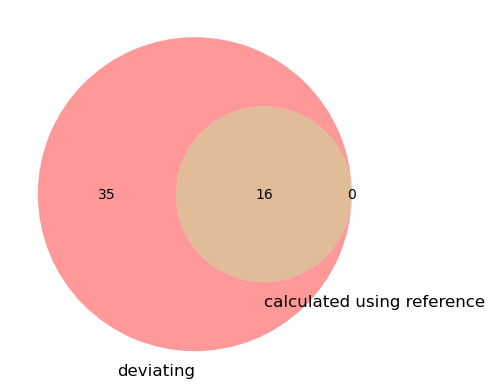

In [9]:
import plotly.express as px
from matplotlib_venn import venn2

def calc_differences(df):
    fig = px.imshow(df.transpose())
    fig.show()

    #sns.clustermap(df)
    print('summed absolute difference of log fold changes: %1.2f' % np.abs(df).values.sum())
    print('average absolute difference of individual log fold change: %1.4f' % (np.abs(df).values.sum() / df.shape[0] / df.shape[1] ))


calc_differences(pixel_fc_df)

insuff = ['C16H12N2', 'C34H70NO6P', 'C39H36N4O7', 'C41H79O13P', 'C41H82NO7P', 'C42H79O10P', 'C43H74NO7P', 'C43H74NO8P', 'C44H78NO10P', 'C44H84NO6P', 'C45H76NO7P', 'C45H78NO7P', 'C45H82NO7P', 'C46H77O10P', 'C46H81NO10P', 'C50H84NO10P']

venn2([set(pixel_fc_df.columns[pixel_fc_df.sum(axis=0) > 0]), set(insuff)], set_labels=('deviating', 'calculated using reference'))



In contrast, when observing the pixel-cell devonvolution independantly, deviations naturally occur rather for selected cells than metabolites. With multiple calculations of overlap-matrices and deconvolution weights, calculation inaccuracies could have possibly been amplified for some cells more than others. This step has been re-engineered after an internal SpaceM method by both Martijn and me and should be processed using the original method in the long run.

In [10]:
calc_differences(raw_fc_df)

summed absolute difference of log fold changes: 333.86
average absolute difference of individual log fold change: 0.0051


When correction and pixel-cell deconvolution are taken together, it can be expected that molecule-specific and cell-specific deviations add up. This can be observed precisely with both the heatmap and the average absolute deviation per data point. As the discrepancies generated by the ion-suppression correction are generally smaller than the ones resulting from (Martijns or my implementation of) pixel-cell deconvolution, I would accept them as they are.

In [11]:
calc_differences(cor_fc_df)

summed absolute difference of log fold changes: 678.92
average absolute difference of individual log fold change: 0.0103
